In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import emoji
import torch
import json
import time

from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# getting the twitter comments
DATA_PATH = '../data/twitter-data-cleaned.txt'
with open(DATA_PATH, 'r',  encoding="utf-8") as f:
    data = f.readlines()
data = [d.strip() for d in data if d.strip() != '']
print('Tweets')
print(data[:3])
print(len(data))

# getting our chosen emojis
SELECTED_EMOJIS_PATH = '../data/best-emojis.json'
with open(SELECTED_EMOJIS_PATH, 'r') as f:
    EMOJIS = json.load(f)
EMOJI_CHARS = [e['char'] for e in EMOJIS]
print('Chosen emojis')
print(EMOJI_CHARS)
print(len(EMOJI_CHARS))

ALL_EMOJIS = set(emoji.emojize(emoji_code) for emoji_code in emoji.UNICODE_EMOJI.values())

Tweets
['💫 IT’S BURGER MONDAY, CBUS! 💫 Order any Gourmet Burger with a draft beer 🍔🍺 ifor just $9.99 when you dine in. 💪 Cer…', 'Stay strong 💪 You are an amazing man. I appreciate the truth that is told.', 'Code Sale Awesome from Styli 💪']
21660
Chosen emojis
['😂', '😍', '😭', '😊', '💕', '😒', '😉', '👌', '👍', '🙏', '👀', '🔥', '💯', '👏', '💪']
15


In [3]:
# # preprocessing the data through nltk
# from nltk.tokenize import TweetTokenizer
# from nltk.tokenize import word_tokenize

# def tokenize_text(text):
#     text = text.lower().strip()
#     words = word_tokenize(text)
#     updated_words = []
#     for w in words:
#         if w.strip() == '':
#             continue
            
#         beginning = 0
#         i = 0
#         while i < len(w):
#             c = w[i]
#             if i > 0 and c in ALL_EMOJIS:
#                 updated_words.append(w[beginning:i])
#                 updated_words.append(c)
#                 beginning = i+1
#                 i += 2
#             i += 1
#         updated_words.append(w[beginning:])
    
#     return updated_words

# for t in data:
#     print(tokenize_text(t))

In [4]:
# preprocessing the data
from parsing import Tokenizer, TokenType, Token
tokenizer = Tokenizer(EMOJI_CHARS)
# take 3 previous words as context for the emoji
context = {e:[] for e in EMOJI_CHARS}
emojiToId = {e:i for i,e in enumerate(EMOJI_CHARS)}

for tweet in data:
    tokens = tokenizer.tokenize(tweet)
    for i,token in enumerate(tokens):
        if token.token_type == TokenType.EMOJIS:
            closest = tokenizer.findClosestNWords(5, tokens, i)
            if closest:
                context[token.raw].append(closest)

for e, words in context.items():
    print(e)
    print(len(words))
    print(words)

😂
1340
[['familiar', 'with', 'my', 'face', 'too'], ['bollywood', 'reality'], ['though', 'your', 'debates', 'be', 'blasphemy'], ['though', 'your', 'debates', 'be', 'blasphemy'], ['game', 'too', 'strong'], ['game', 'too', 'strong'], ['rub', 'for', 'the', 'razzle', 'dazzle'], ['to', 'hang', 'up', 'on', 'santa'], ['stones', 'may', 'break', 'my', 'bones'], ['her', 'for', 'hate', 'crime', 'speech'], ['got', 'this', 'soon', 'youre', 'done'], ['19th', 'to', 'yung', 'flight', 'school'], ['that', 'julius', 'erving'], ['mrji', 'krlo', 'tum', 'bullywood', 'walo'], ['aama', 'wait', 'and', 'watch'], ['the', 'day', 'you', 'crossed', 'bro'], ['get', 'addicted', 'like', 'last', 'time'], ['as', 'she', 'should', 'folks', 'play'], ['should', 'folks', 'play', 'too', 'much'], ['should', 'folks', 'play', 'too', 'much'], ['to', 'mind', 'their', 'own', 'business'], ['abnormal', 'behavior', 'hahaha', 'chaaar', 'cheer'], ['him', 'i', 'need', 'that', 'btw'], ['that', 'a', 'million', 'times', 'before'], ['30', 'an

In [5]:
# making X and y for TFIDF as a baseline idea of how good our accuracy can expect to be
X_words = []
y = []
sentences = set()
for e, words in context.items():
    for i,word_list in enumerate(words):
        sentence = ' '.join(word_list)
        if sentence in sentences:
            continue
        sentences.add(sentence)
        X_words.append(sentence)
        y.append(emojiToId[e])
print(len(y))

13136


In [6]:
print(X_words[0])
print(y[0])

familiar with my face too
0


In [13]:
# attempting to use tfidf and RF
# WARNING: can take a decent amount of time: 5 mins or so?
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_words)

model = RandomForestClassifier(n_estimators=300)
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.19 (+/- 0.01)


In [7]:
# making X and y for RNN
X_words = []
y = []
sentences = set()
for e, words in context.items():
    for i, sentence in enumerate(words):
        check = ' '.join(sentence)
        if check in sentences:
            continue
        sentences.add(check)
        X_words.append(sentence)
        y.append(emojiToId[e])
print(X_words[0])
print(len(y))

['familiar', 'with', 'my', 'face', 'too']
13136


In [11]:
# making word embeddings for RNN
UNK = "<unk>"
WORDEMBSIZE = 64
W2V_WINDOW = 7
W2V_COUNT = 1
W2V_EPOCH=100

def makeVocab(text):
    vocab = set()
    for sentences in text:
        for word in sentences:
            vocab.add(word)
    return vocab

def makeEmbModel(data):
    docs = [[UNK]]
    docs.extend(data)
    model = Word2Vec(window=W2V_WINDOW, min_count=W2V_COUNT, size=WORDEMBSIZE)
    model.build_vocab(docs)
    model.train(docs, total_examples=len(docs), epochs=W2V_EPOCH)
    print(model)
    return model

def makeEmbeddings(data, model, vocab):
    vecData = []
    for sentence in data:
        wordEmbs = []
        for word in sentence:
            if word in vocab:
#                 print(type(model[word]))
#                 print(model[word])
                wordEmbs.append(model[word])
            else:
                wordEmbs.append(np.zeros(WORDEMBSIZE))
        wordEmbs = torch.FloatTensor(wordEmbs)
        vecData.append(wordEmbs)
    return vecData

In [12]:
# continue making word embeddings
X_words_train, X_words_test, y_train, y_test = train_test_split(X_words, y, test_size=0.2, random_state=42)
vocab = makeVocab(X_words_train)
emb_model = makeEmbModel(X_words_train)
vocab = set(list(emb_model.wv.vocab.keys()))
X_train = makeEmbeddings(X_words_train, emb_model, vocab)
X_test = makeEmbeddings(X_words_test, emb_model, vocab)

print(X_words_train[0])
print(X_train[0])
print(y_train[0])

Word2Vec(vocab=9219, size=64, alpha=0.025)


/Users/ericsun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['fb', 'friend', 'requests', 'sweetie', 'haha']
tensor([[-1.0044e+00,  2.1917e-01,  3.4713e-01,  7.4545e-01,  1.5053e-01,
         -7.4599e-02,  8.0553e-02, -7.8371e-02, -3.0781e-01,  1.8797e-01,
          8.1633e-01, -7.4608e-01,  1.3873e-01, -7.1240e-01, -7.0175e-01,
         -7.0514e-01, -6.1132e-01,  1.6544e-01, -2.1550e-01, -1.6149e-01,
          6.0706e-01,  2.4262e-01,  2.2180e-01, -7.4702e-01, -8.0453e-01,
          2.7359e-02,  4.9089e-01, -3.9452e-01,  6.8348e-01, -8.3217e-01,
          7.8970e-01,  3.4672e-01,  4.2505e-01,  3.0714e-01,  6.5697e-04,
          6.7786e-01,  6.1108e-02,  1.0531e-01,  4.5356e-01,  7.7986e-01,
          3.6009e-01, -8.8239e-01,  5.0725e-01, -7.6493e-01,  6.7549e-01,
          7.8616e-01, -1.2480e-01,  1.8160e-01,  1.2046e-02,  6.5300e-02,
          4.4331e-01,  1.6640e-01,  6.6669e-01, -3.5800e-02, -6.2436e-01,
          9.8748e-02,  9.3570e-01, -7.5201e-01, -1.1181e+00,  5.1232e-02,
         -2.8590e-02, -3.9926e-01,  6.7815e-01,  3.8079e-01],
  

In [13]:
# RNN building to predict result
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [14]:
# RNN model
class RNN(nn.Module):
    def __init__(self, input_dim, h, output_dim = 15):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, h, dropout=0.2)
        self.finalLayer = nn.Linear(h, output_dim)
        self.input_dim = input_dim
        self.hidden_dim = h
        self.output_dim =  output_dim
#         self.word_embeddings = nn.Embedding(vocab_size, input_dim)
        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()
    
    def compute_loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)
    
    def forward(self, inputs):
        out, hidden = self.rnn(inputs)
        hidden = hidden.contiguous().view(-1,self.hidden_dim)
        predicted_vector = self.softmax(self.finalLayer(hidden))
        return predicted_vector



-------------
EPOCH: 1
Training started for epoch:1


/Users/ericsun/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


/Users/ericsun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Training completed for epoch: 1
Time for train: 18.64618992805481
Accuracy: 0.08774771341463415
Validation started for epoch:1



Validation completed for epoch: 1
Time for validation: 1.7996320724487305
Accuracy: 0.1013719512195122


-------------
EPOCH: 2
Training started for epoch:2



Training completed for epoch: 2
Time for train: 16.717698097229004
Accuracy: 0.12823932926829268
Validation started for epoch:2



Validation completed for epoch: 2
Time for validation: 1.9033348560333252
Accuracy: 0.12347560975609756


-------------
EPOCH: 3
Training started for epoch:3



Training completed for epoch: 3
Time for train: 31.95688772201538
Accuracy: 0.14977134146341464
Validation started for epoch:3



Validation completed for epoch: 3
Time for validation: 2.9243059158325195
Accuracy: 0.12766768292682926


-------------
EPOCH: 4
Training started for epoch:4



Training completed for epoch: 4
Time for train: 21.169124126434326
Accuracy: 0.15958460365853658
Validation started for epoch:4



Validation completed for epoch: 4
Time for validation: 1.7481000423431396
Accuracy: 0.14634146341463414


-------------
EPOCH: 5
Training started for epoch:5



Training completed for epoch: 5
Time for train: 17.09027600288391
Accuracy: 0.17016006097560976
Validation started for epoch:5



Validation completed for epoch: 5
Time for validation: 1.7720229625701904
Accuracy: 0.14900914634146342


-------------
EPOCH: 6
Training started for epoch:6



Training completed for epoch: 6
Time for train: 15.836811065673828
Accuracy: 0.17530487804878048
Validation started for epoch:6



Validation completed for epoch: 6
Time for validation: 1.7517030239105225
Accuracy: 0.15396341463414634


-------------
EPOCH: 7
Training started for epoch:7



Training completed for epoch: 7
Time for train: 15.615591764450073
Accuracy: 0.18140243902439024
Validation started for epoch:7



Validation completed for epoch: 7
Time for validation: 1.7447471618652344
Accuracy: 0.16196646341463414


-------------
EPOCH: 8
Training started for epoch:8



Training completed for epoch: 8
Time for train: 15.729008674621582
Accuracy: 0.18521341463414634
Validation started for epoch:8



Validation completed for epoch: 8
Time for validation: 1.752082109451294
Accuracy: 0.16501524390243902


-------------
EPOCH: 9
Training started for epoch:9



Training completed for epoch: 9
Time for train: 16.203544855117798
Accuracy: 0.18873856707317074
Validation started for epoch:9



Validation completed for epoch: 9
Time for validation: 1.7603342533111572
Accuracy: 0.17111280487804878


-------------
EPOCH: 10
Training started for epoch:10



Training completed for epoch: 10
Time for train: 15.53649377822876
Accuracy: 0.19226371951219512
Validation started for epoch:10



Validation completed for epoch: 10
Time for validation: 1.7659330368041992
Accuracy: 0.16958841463414634


-------------
EPOCH: 11
Training started for epoch:11



Training completed for epoch: 11
Time for train: 15.589507818222046
Accuracy: 0.19483612804878048
Validation started for epoch:11



Validation completed for epoch: 11
Time for validation: 1.8081638813018799
Accuracy: 0.16882621951219512


-------------
EPOCH: 12
Training started for epoch:12



Training completed for epoch: 12
Time for train: 15.609864950180054
Accuracy: 0.1956935975609756
Validation started for epoch:12



Validation completed for epoch: 12
Time for validation: 1.724982738494873
Accuracy: 0.171875


-------------
EPOCH: 13
Training started for epoch:13



Training completed for epoch: 13
Time for train: 15.541465044021606
Accuracy: 0.20150533536585366
Validation started for epoch:13



Validation completed for epoch: 13
Time for validation: 1.8670151233673096
Accuracy: 0.16844512195121952


-------------
EPOCH: 14
Training started for epoch:14



Training completed for epoch: 14
Time for train: 15.762295007705688
Accuracy: 0.2030297256097561
Validation started for epoch:14



Validation completed for epoch: 14
Time for validation: 1.9263970851898193
Accuracy: 0.16730182926829268


-------------
EPOCH: 15
Training started for epoch:15



Training completed for epoch: 15
Time for train: 15.697579145431519
Accuracy: 0.20531631097560976
Validation started for epoch:15



Validation completed for epoch: 15
Time for validation: 1.782027006149292
Accuracy: 0.16844512195121952


-------------
EPOCH: 16
Training started for epoch:16



Training completed for epoch: 16
Time for train: 15.78197979927063
Accuracy: 0.20655487804878048
Validation started for epoch:16



Validation completed for epoch: 16
Time for validation: 1.8119559288024902
Accuracy: 0.17492378048780488


-------------
EPOCH: 17
Training started for epoch:17



Training completed for epoch: 17
Time for train: 15.905030250549316
Accuracy: 0.21169969512195122
Validation started for epoch:17



Validation completed for epoch: 17
Time for validation: 1.8421518802642822
Accuracy: 0.1676829268292683


-------------
EPOCH: 18
Training started for epoch:18



Training completed for epoch: 18
Time for train: 15.750341176986694
Accuracy: 0.21655868902439024
Validation started for epoch:18



Validation completed for epoch: 18
Time for validation: 1.7889862060546875
Accuracy: 0.16158536585365854


-------------
EPOCH: 19
Training started for epoch:19



Training completed for epoch: 19
Time for train: 15.783357858657837
Accuracy: 0.21608231707317074
Validation started for epoch:19



Validation completed for epoch: 19
Time for validation: 1.7686069011688232
Accuracy: 0.16653963414634146


-------------
EPOCH: 20
Training started for epoch:20



Training completed for epoch: 20
Time for train: 15.748568058013916
Accuracy: 0.2185594512195122
Validation started for epoch:20



Validation completed for epoch: 20
Time for validation: 1.7876639366149902
Accuracy: 0.17073170731707318


-------------
EPOCH: 21
Training started for epoch:21



Training completed for epoch: 21
Time for train: 17.54493999481201
Accuracy: 0.22379954268292682
Validation started for epoch:21



Validation completed for epoch: 21
Time for validation: 1.7871980667114258
Accuracy: 0.17073170731707318


-------------
EPOCH: 22
Training started for epoch:22



Training completed for epoch: 22
Time for train: 15.898218870162964
Accuracy: 0.22389481707317074
Validation started for epoch:22



Validation completed for epoch: 22
Time for validation: 36.77978491783142
Accuracy: 0.17035060975609756


-------------
EPOCH: 23
Training started for epoch:23



Training completed for epoch: 23
Time for train: 21.54794406890869
Accuracy: 0.22989710365853658
Validation started for epoch:23



Validation completed for epoch: 23
Time for validation: 2.350167989730835
Accuracy: 0.16692073170731708


-------------
EPOCH: 24
Training started for epoch:24



Training completed for epoch: 24
Time for train: 18.60494303703308
Accuracy: 0.22970655487804878
Validation started for epoch:24



Validation completed for epoch: 24
Time for validation: 1.878744125366211
Accuracy: 0.16996951219512196


-------------
EPOCH: 25
Training started for epoch:25



Training completed for epoch: 25
Time for train: 16.532710075378418
Accuracy: 0.23123094512195122
Validation started for epoch:25



Validation completed for epoch: 25
Time for validation: 1.7734348773956299
Accuracy: 0.16577743902439024


-------------
EPOCH: 26
Training started for epoch:26



Training completed for epoch: 26
Time for train: 15.724495887756348
Accuracy: 0.23580411585365854
Validation started for epoch:26



Validation completed for epoch: 26
Time for validation: 1.83302903175354
Accuracy: 0.17035060975609756


-------------
EPOCH: 27
Training started for epoch:27



Training completed for epoch: 27
Time for train: 16.290897846221924
Accuracy: 0.23389862804878048
Validation started for epoch:27



Validation completed for epoch: 27
Time for validation: 1.7308669090270996
Accuracy: 0.16349085365853658


-------------
EPOCH: 28
Training started for epoch:28



Training completed for epoch: 28
Time for train: 16.14026713371277
Accuracy: 0.24085365853658536
Validation started for epoch:28



Validation completed for epoch: 28
Time for validation: 1.8422579765319824
Accuracy: 0.16234756097560976


-------------
EPOCH: 29
Training started for epoch:29



Training completed for epoch: 29
Time for train: 16.060348987579346
Accuracy: 0.24342606707317074
Validation started for epoch:29



Validation completed for epoch: 29
Time for validation: 1.8072009086608887
Accuracy: 0.16463414634146342


-------------
EPOCH: 30
Training started for epoch:30



Training completed for epoch: 30
Time for train: 16.00708794593811
Accuracy: 0.24275914634146342
Validation started for epoch:30



Validation completed for epoch: 30
Time for validation: 1.7823259830474854
Accuracy: 0.1638719512195122


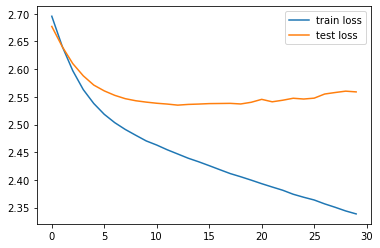

In [15]:
# running epochs for training and validation
HIDDEN_DIM = 128
EPOCHS = 30

model = RNN(WORDEMBSIZE, HIDDEN_DIM, 15)
optimizer = optim.SGD(model.parameters(),lr=0.0005, momentum=0.9)
train_loss = []
test_loss = []
for epoch in range(EPOCHS):
    print("\n\n-------------")
    print("EPOCH: {}".format(epoch + 1))
    running_loss = 0.0
    model.train()
    optimizer.zero_grad()
    print("Training started for epoch:{}".format(epoch + 1))
    X_train, y_train = shuffle(X_train, y_train)
    start_time = time.time()
    correct = total = 0
    minibatch_size = 16
    N = len(y_train)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for idx in range(minibatch_size):
            text = X_train[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_train[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            if loss is None:
                loss = text_loss
            else:
                loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / N)
    print("Training completed for epoch: {}".format(epoch + 1))
    print("Time for train: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))
    
    #validation
    running_loss = 0.0
    model.eval()
    optimizer.zero_grad()
    print("Validation started for epoch:{}".format(epoch + 1))
    X_test, y_test = shuffle(X_test, y_test)
    start_time = time.time()
    correct = total = 0
    minibatch_size = 16
    N = len(y_test)
    for minibatch_idx in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        for idx in range(minibatch_size):
            text = X_test[minibatch_idx * minibatch_size + idx]
            text = torch.unsqueeze(text, 1)
            labelIdx = y_test[minibatch_idx * minibatch_size + idx]
            log_probs = model(text)
            text_loss = model.compute_loss(log_probs.view(1,-1), torch.tensor([labelIdx]))
            running_loss += text_loss
            pred_label = torch.argmax(log_probs)
            correct += int(pred_label == labelIdx)
            total += 1
    test_loss.append(running_loss / N)
    print("Validation completed for epoch: {}".format(epoch + 1))
    print("Time for validation: {}".format(time.time() - start_time))
    print("Accuracy: {}".format(correct / total))

plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()